In [178]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

In [47]:
column_names=[
    'age', 'class', 'ind_code_det', 'occ_code_det', 'education', 'wage_hr', 'enroll_edu', 'marital',
    'ind_code_maj', 'occ_code_maj', 'race', 'hisp_origin', 'sex', 'lab_union', 'reason_unemp',
    'emp_status', 'cap_gain', 'cap_loss', 'dividend', 'tax_filer_stat', 'prev_res_area', 'prev_res_state',
    'fam_state', 'fam_state_sum', 'inst_weight', 'migr_change_msa', 'migr_change_reg', 'migr_move_msa', 'lived_1yr',
    'migr_sunbelt', 'num_ppl_worked', 'fam_members_u18', 'birth_dad', 'birth_mom', 'birth_self', 'citizenship',
    'employed_status', 'veteran_admin', 'veteran_benefit', 'weeks_worked', 'year', 'income']

predictors = [
    'age', 'class', 'ind_code_det', 'occ_code_det', 'education', 'wage_hr', 'enroll_edu', 'marital',
    'ind_code_maj', 'occ_code_maj', 'race', 'hisp_origin', 'sex', 'lab_union', 'reason_unemp',
    'emp_status', 'cap_gain', 'cap_loss', 'dividend', 'tax_filer_stat', 'prev_res_area', 'prev_res_state',
    'fam_state', 'fam_state_sum', 'inst_weight', 'migr_change_msa', 'migr_change_reg', 'migr_move_msa', 'lived_1yr',
    'migr_sunbelt', 'num_ppl_worked', 'fam_members_u18', 'birth_dad', 'birth_mom', 'birth_self', 'citizenship',
    'employed_status', 'veteran_admin', 'veteran_benefit', 'weeks_worked', 'year']

categorical_predictors = [
    'class', 'ind_code_det', 'occ_code_det', 'education', 'enroll_edu', 'marital',
    'ind_code_maj', 'occ_code_maj', 'race', 'hisp_origin', 'sex', 'lab_union', 'reason_unemp',
    'emp_status', 'tax_filer_stat', 'prev_res_area', 'prev_res_state',
    'fam_state', 'fam_state_sum', 'migr_change_msa', 'migr_change_reg', 'migr_move_msa', 'lived_1yr',
    'migr_sunbelt', 'fam_members_u18', 'birth_dad', 'birth_mom', 'birth_self', 'citizenship',
    'employed_status', 'veteran_admin', 'veteran_benefit', 'year']

def clean_data(data):
    data.columns=column_names

    le = LabelEncoder()
    for pred in categorical_predictors:
        data[pred] = le.fit_transform(data[pred])
    
    data['>50K'] = data['income'].apply(lambda x: 1 if '+' in x else 0)

    return data


In [176]:
def get_metrics(y_test, y_pred):
    print("confusion_matrix:")
    # print(confusion_matrix(y_test, y_pred))

    # Plot confusion matrix, showing the values in each cell
    cm = confusion_matrix(y_test, y_pred)
    plt.matshow(cm, cmap=plt.cm.Blues)
    # Show the values
    for x in range(cm.shape[0]):
        for y in range(cm.shape[1]):
            plt.text(x, y, str(cm[x,y]), va='center', ha='center')

    # Set axes
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100}%")
    print(f"Recall: {recall_score(y_test, y_pred) * 100}%")
    print(f"Precision: {precision_score(y_test, y_pred) * 100}%")
    

In [154]:
def find_threshold(y_pred, y_true):
    p, r, thresholds = precision_recall_curve(y_true, y_pred)

    f1 = 2 * (p[:-1] * r[:-1]) / (p[:-1] + r[:-1])

    # Plot the model precision-recall curve

    df = pd.DataFrame({'Precision': p[:-1], 'Recall': r[:-1], 'Threshold': thresholds})

    # df.set_index('Threshold', inplace=True)

    # df["Accuracy"] = df.apply(lambda row: accuracy_score(y_true, y_pred >= row.name), axis=1)

    # USe f1 to find thresh
    threshold = df.iloc[f1.argmax()]['Threshold']

    df.plot(x="Threshold", y=["Precision", "Recall"], figsize=(10, 5), grid=True)
    # Add a vertical line at the threshold that maximizes F1 score
    plt.vlines(threshold, 0, 1, linestyle='--')

    return threshold


In [115]:
data = pd.read_csv('../census-income.data',header=None)

data = clean_data(data)

data.head(2)

,age,class,ind_code_det,occ_code_det,education,wage_hr,enroll_edu,marital,ind_code_maj,occ_code_maj,...,birth_mom,birth_self,citizenship,employed_status,veteran_admin,veteran_benefit,weeks_worked,year,income,>50K
0,73,3,0,0,12,0,2,6,14,6,...,40,40,4,0,1,2,0,1,- 50000.,0
1,58,6,4,34,16,0,2,0,4,8,...,40,40,4,0,1,2,52,0,- 50000.,0


In [116]:
X = data[predictors]
y = data['>50K']

In [117]:
#import and prepare test data
test = pd.read_csv('../census-income.test',header=None)
test.columns=column_names
le = LabelEncoder()
for pred in categorical_predictors:
    test[pred] = le.fit_transform(test[pred])
test['>50K'] = test['income'].apply(lambda x: 1 if '+' in x else 0)

In [118]:
X_test = test[predictors]
y_test = test['>50K']

In [81]:
# Create a basic AdaBoost classifier to see what can be done without tuning
clf = AdaBoostClassifier(n_estimators=500, learning_rate=1, random_state=0)
clf.fit(X, y)


AdaBoostClassifier(learning_rate=1, n_estimators=500, random_state=0)

In [82]:
y_pred_proba_train = clf.predict_proba(X)[:, 1]

0.49956268705873547

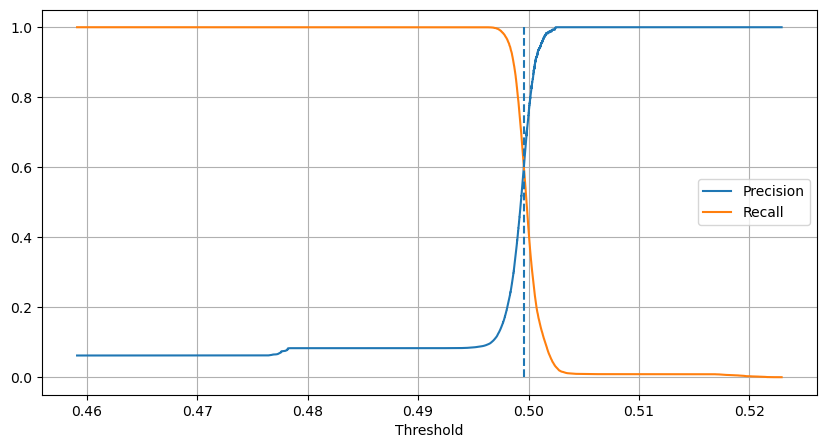

In [157]:
threshold = find_threshold(y_pred_proba_train, y)
threshold

confusion_matrix:
Accuracy: 91.28926845893226%
Recall: 81.65211768509538%
Precision: 40.06822148183405%


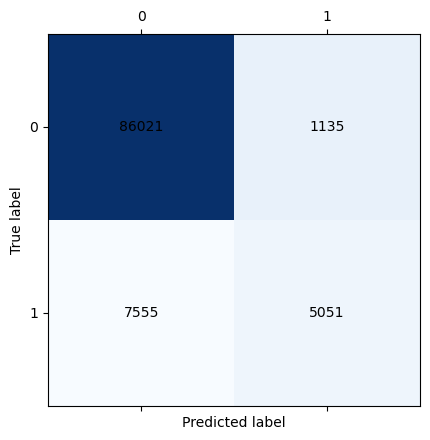

In [181]:
y_pred_proba_test = clf.predict_proba(X_test)[:, 1]
threshold = 0.499
y_pred = (y_pred_proba_test > threshold).astype(int)

get_metrics(y_test, y_pred)

In [87]:
# Tune hyperparameters for AdaBoost using random grid search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 1000, num = 10)]

# Learning rate
learning_rate = [0.01, 0.1, 0.25, 0.5, 0.75, 1]

base_estimators = [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2), DecisionTreeClassifier(max_depth=5)]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'estimator': base_estimators}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
clf_tuned = AdaBoostClassifier()

# Random search of parameters


clf_random = RandomizedSearchCV(estimator = clf_tuned, 
                                param_distributions = random_grid, 
                                n_iter = 50, 
                                cv = 2, 
                                verbose=2, 
                                random_state=42, 
                                n_jobs = -1)

# Fit the random search model
clf_random.fit(X, y)

clf_random.best_params_

Fitting 2 folds for each of 50 candidates, totalling 100 fits
[CV] END estimator=DecisionTreeClassifier(max_depth=1), learning_rate=0.75, n_estimators=261; total time=  52.9s
[CV] END estimator=DecisionTreeClassifier(max_depth=1), learning_rate=0.75, n_estimators=261; total time=  53.0s
[CV] END estimator=DecisionTreeClassifier(max_depth=1), learning_rate=0.1, n_estimators=1000; total time= 3.5min
[CV] END estimator=DecisionTreeClassifier(max_depth=1), learning_rate=0.1, n_estimators=1000; total time= 3.5min
[CV] END estimator=DecisionTreeClassifier(max_depth=5), learning_rate=0.5, n_estimators=366; total time= 4.6min
[CV] END estimator=DecisionTreeClassifier(max_depth=5), learning_rate=0.5, n_estimators=366; total time= 4.6min
[CV] END estimator=DecisionTreeClassifier(max_depth=2), learning_rate=0.1, n_estimators=894; total time= 5.1min
[CV] END estimator=DecisionTreeClassifier(max_depth=2), learning_rate=0.1, n_estimators=894; total time= 5.1min
[CV] END estimator=DecisionTreeClassif

{'n_estimators': 366,
 'learning_rate': 0.5,
 'estimator': DecisionTreeClassifier(max_depth=2)}

In [88]:
clf_random.best_params_

{'n_estimators': 366,
 'learning_rate': 0.5,
 'estimator': DecisionTreeClassifier(max_depth=2)}

In [105]:
tuned_clf2 = AdaBoostClassifier(n_estimators=515, learning_rate=1, estimator=DecisionTreeClassifier(max_depth=5))

tuned_clf2.fit(X, y)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5),
                   learning_rate=1, n_estimators=515)

0.49748743718592964

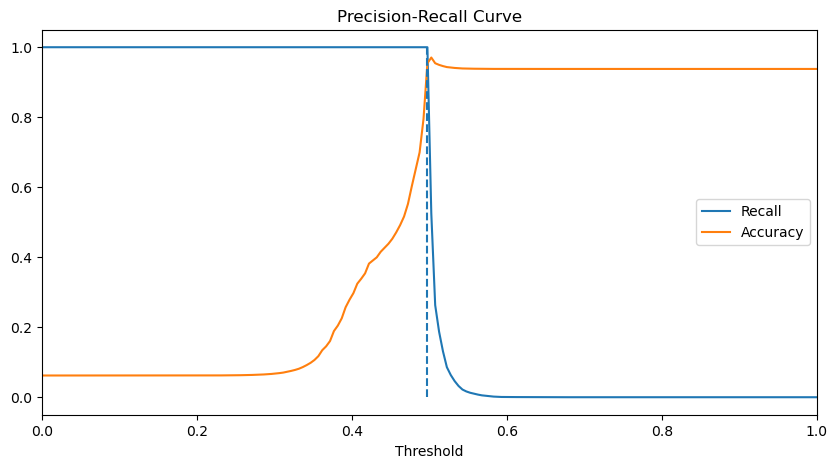

In [140]:
tuned_clf2_proba_train = tuned_clf2.predict_proba(X)[:, 1]

threshold_2 = find_threshold(tuned_clf2_proba_train, y)

tuned_clf2_proba_test = tuned_clf2.predict_proba(X_test)[:, 1]
tuned_clf2_pred = (tuned_clf2_proba_test > threshold_2).astype(int)

threshold_2

In [141]:
get_metrics(y_test, tuned_clf2_pred)

confusion_matrix:
[[87810  5766]
 [ 2484  3702]]
Accuracy: 91.73031815721417%
Recall: 59.84481086323957%
